In [1]:
import json
import numpy as np
import os.path
from os.path import exists
import pandas as pd
from scipy.stats import gaussian_kde
from corner import corner

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from inspect_results_helper_functions import * 

root = '../../..'
style.use(root+'/Figures/plotting.mplstyle')

import sys
sys.path.append(root+'/Figures')
from fig_helper_functions import calculate_chiEff, calculate_chiP

### Read in job lists

In [2]:
num_injections = 400
joblists_all = {}
joblists_inspected = {}

pop_names = ['population1_highSpinPrecessing', 'population2_mediumSpin', 'population3_lowSpinAligned']

for pop in pop_names:
    
    # load all jobs
    f = f'{root}/Code/IndividualInference/injlist_{pop}_' + str(num_injections) + 'events.txt'
    jobs = np.loadtxt(f)
    
    job_list = [int(job) for job in np.sort(jobs)]
    
    joblists_all[pop] = job_list
    
    # look for jobs already inspected
    f2 = f'{pop}_jobs_checked.txt'
    if exists(f2):
        job_list_inspected = np.loadtxt(f2)
        try:
            print(len(job_list_inspected))
            joblists_inspected[pop] = job_list_inspected
        except: 
            joblists_inspected[pop] = [job_list_inspected]
    else: 
        joblists_inspected[pop] = []

399
397
397


### Determine which jobs are done versus which aren't

In [3]:
joblists_finished = {}
joblists_missing = {}

for pop in pop_names: 
    
    print(pop)
    
    # Figure out which jobs we still need to look at
    jobs_all = joblists_all[pop]
    jobs_inspected = joblists_inspected[pop]
    jobs_remaining = [j for j in jobs_all if j not in jobs_inspected]
    
    # Look through them
    jobs_missing, job_list_finished = find_all_missing(pop, jobs_remaining)
    joblists_finished[pop] = np.concatenate((jobs_inspected, job_list_finished))
    joblists_missing[pop] = jobs_missing
    
    # Print how many 
    print(f'{len(joblists_finished[pop])} finished, {len(job_list_finished)} to plot')
    print('missing jobs: ', jobs_missing)
    print()

population1_highSpinPrecessing
399 finished, 0 to plot
missing jobs:  [4074]

population2_mediumSpin
397 finished, 0 to plot
missing jobs:  [4301, 6505, 8630]

population3_lowSpinAligned
397 finished, 0 to plot
missing jobs:  [5686, 6297, 9084]



### Plot histogram of parameters for events that have finished

In [4]:
f_root = '../../InjectedPopulationParameters/'
pop1 = pd.read_json(f_root+'population1_highSpinPrecessing_fullmassrange.json')
pop2 = pd.read_json(f_root+'population2_mediumSpin_fullmassrange.json')
pop3 = pd.read_json(f_root+'population3_lowSpinAligned_fullmassrange.json')

In [5]:
def calculate_params_dict(joblist, pops=[pop1, pop2, pop3]):
    
    params_dict = {}

    for i,pop in enumerate(pops):

        chis = []
        costs = []
        chieffs = []
        chips = []
        m1s = []
        m2s = []
        qs = []
        zs = []

        for job in joblist[pop_names[i]]:

            JOB_ID = int(job)

            # masses 
            m1 = pop.m1[JOB_ID]
            m2 = pop.m2[JOB_ID]
            m1s += [m1]
            m2s += [m2]

            # redshift
            zs += [pop.z[JOB_ID]]

            # spin magnitude
            chi1 = np.sqrt(pop.s1x[JOB_ID]**2 + pop.s1y[JOB_ID]**2 + pop.s1z[JOB_ID]**2)
            chi2 = np.sqrt(pop.s2x[JOB_ID]**2 + pop.s2y[JOB_ID]**2 + pop.s2z[JOB_ID]**2)
            chis += [chi1]
            chis += [chi2]

            # tilt angle
            cost1 = pop.s1z[JOB_ID]/chi1
            cost2 = pop.s2z[JOB_ID]/chi2
            costs += [cost1]
            costs += [cost2]

            # chi effective
            q = m2/m1
            qs += [q]
            chieff = calculate_chiEff(chi1, chi2, cost1, cost2, q)
            chieffs += [chieff]

            # chi p
            sint1 = np.sin(np.arccos(cost1))
            sint2 = np.sin(np.arccos(cost2))
            chip = calculate_chiP(chi1, chi2, sint1, sint2, q)
            chips += [chip]

        params_dict[pop_names[i]] = {
            'chi':chis, 
            'cost':costs, 
            'chieff':chieffs, 
            'chip':chips, 
            'm1':m1s,
            'm2':m2s,
            'q':qs,
            'z':zs
        }
        
    return params_dict

In [6]:
# Finished vs. not finished job lists
params_dict_finished = calculate_params_dict(joblists_finished)
params_dict_missing = calculate_params_dict(joblists_missing)

In [7]:
# Set up grids to evaluate KDEs on
m1_grid = np.linspace(6,85,500)
m2_grid =  np.linspace(6,85,500)
q_grid =  np.linspace(0,1,500)
z_grid =  np.linspace(0,1.5,500)

# make and evaluate kdes
m1_kde = reflective_kde_on_grid(np.concatenate((np.asarray(pop1.m1), np.asarray(pop2.m1), np.asarray(pop3.m1))), m1_grid)
m2_kde = reflective_kde_on_grid(np.concatenate((np.asarray(pop1.m2), np.asarray(pop2.m2), np.asarray(pop3.m2))), m2_grid)

q = np.concatenate((np.asarray(pop1.m2/pop1.m1),  np.asarray(pop2.m2/pop2.m1),  np.asarray(pop3.m2/pop3.m1)))
q_kde = reflective_kde_on_grid(q, q_grid)

z_kde =reflective_kde_on_grid(np.concatenate((np.asarray(pop1.z), np.asarray(pop2.z), np.asarray(pop3.z))), z_grid)

# put KDEs into dict
kde_dict = {
    'm1':m1_kde, 
    'm2':m2_kde, 
    'q':q_kde, 
    'z':z_kde
}

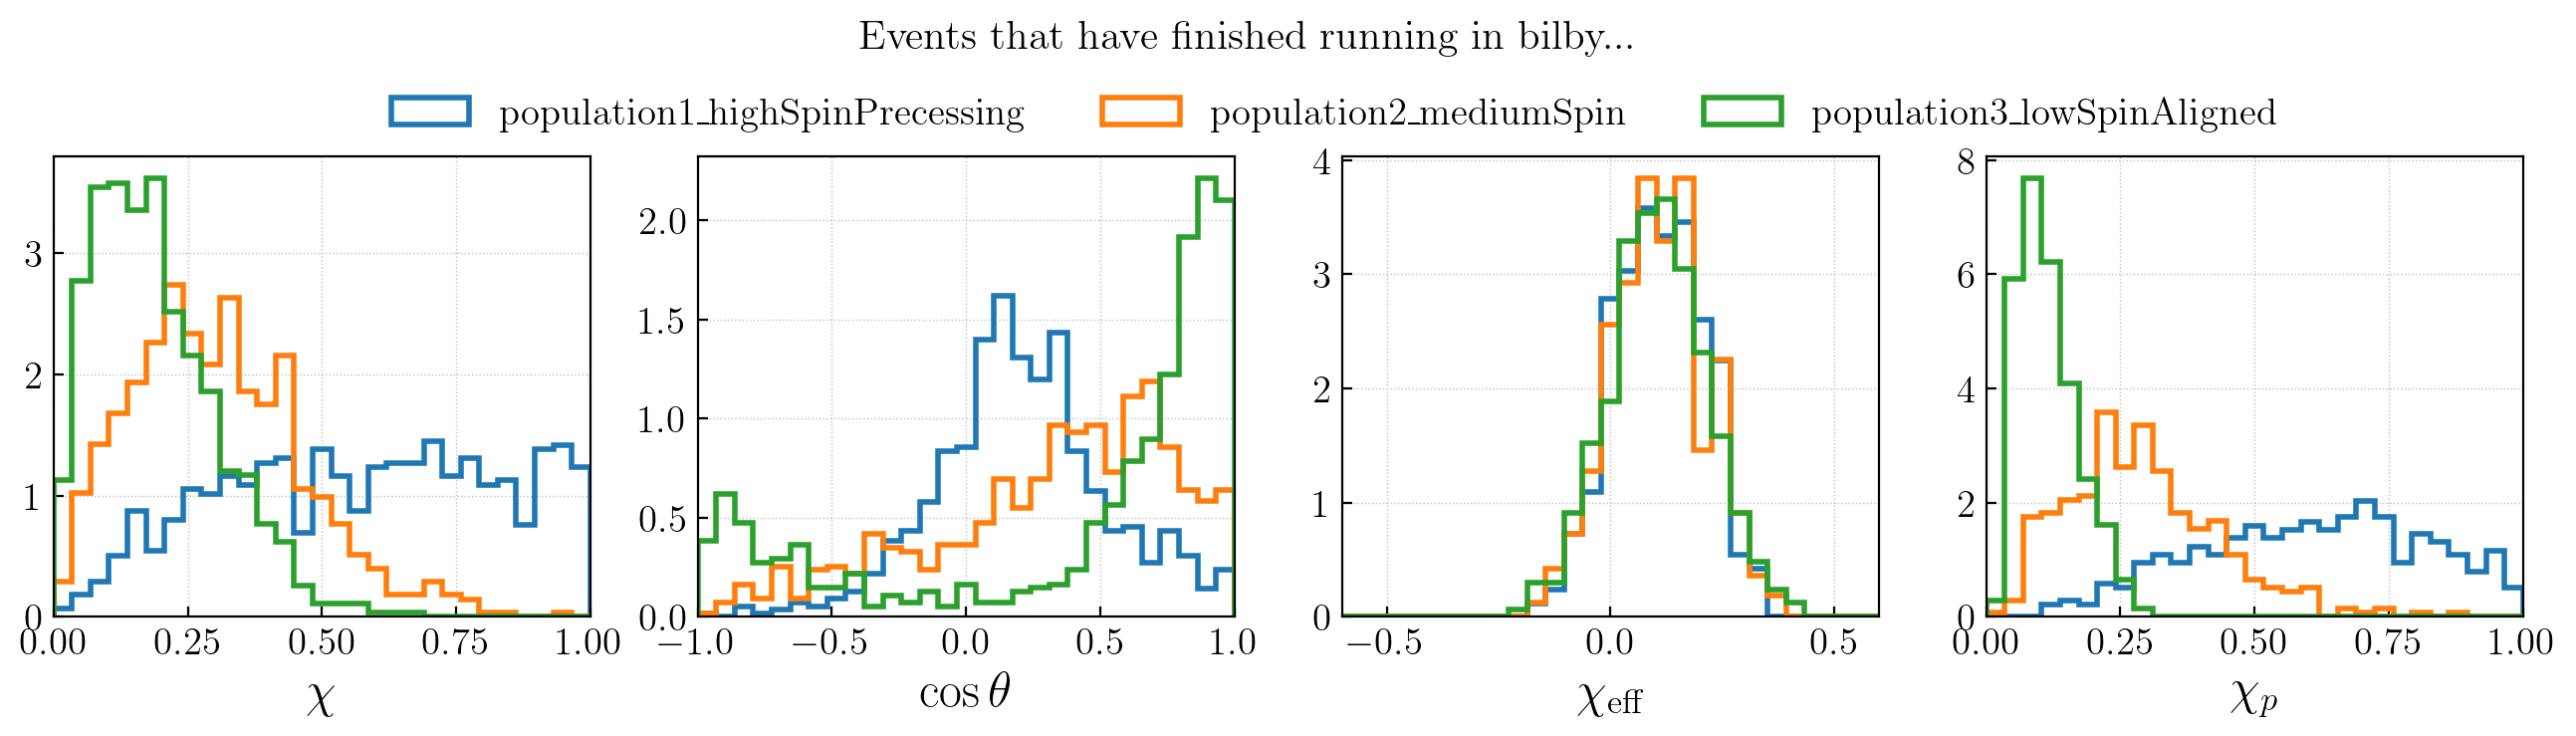

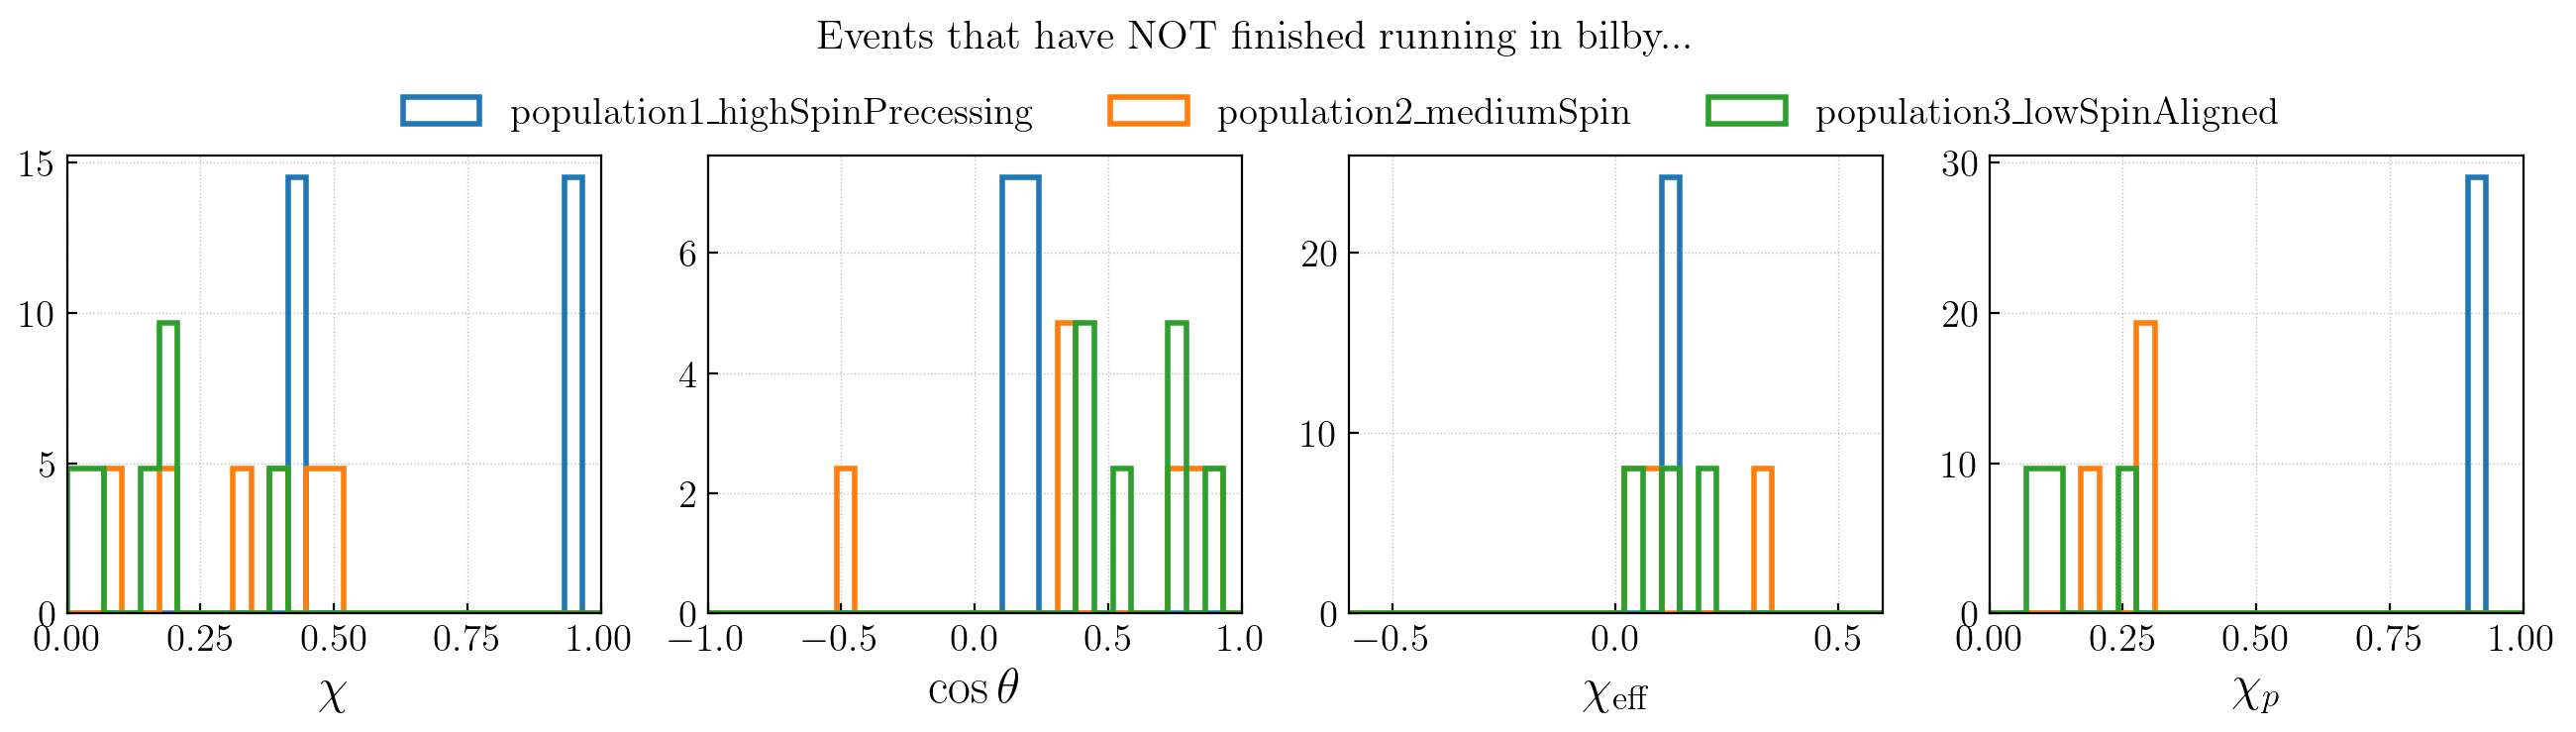

In [8]:
labels = [r'$\mathrm{\textsc{HighSpinPrecessing}}$', r'$\mathrm{\textsc{MediumSpin}}$', r'$\mathrm{\textsc{LowSpinAligned}}$']

nbins=30

for params_dict, ttl in zip([params_dict_finished, params_dict_missing], 
                              ['finished', 'NOT finished']):

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

    for pop in pop_names:

        # spin magnitude
        axes[0].hist(params_dict[pop]['chi'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2, label=pop)
        axes[0].set_xlim(0,1)

        # tilt angle
        axes[1].hist(params_dict[pop]['cost'], density=True, bins=np.linspace(-1, 1, nbins), histtype='step', lw=2)
        axes[1].set_xlim(-1,1)

        # chi effective
        axes[2].hist(params_dict[pop]['chieff'], density=True, bins=np.linspace(-0.6, 0.6, nbins), histtype='step', lw=2)
        axes[2].set_xlim(-0.6,0.6)

        # chi p
        axes[3].hist(params_dict[pop]['chip'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2)
        axes[3].set_xlim(0, 1)

    axes[0].legend(bbox_to_anchor=(0.6, 1.02, 1., .102), loc='lower left',
                          ncol=3,  borderaxespad=0.)

    axes[0].set_xlabel(r'$\chi$')
    axes[1].set_xlabel(r'$\cos\theta$')
    axes[2].set_xlabel(r'$\chi_\mathrm{eff}$')
    axes[3].set_xlabel(r'$\chi_p$')  

    for ax in axes: 
        ax.grid(ls=':', color='silver', lw=0.5)

    plt.suptitle(f'Events that have {ttl} running in bilby...', y=1.11, fontsize=15)

    plt.show()

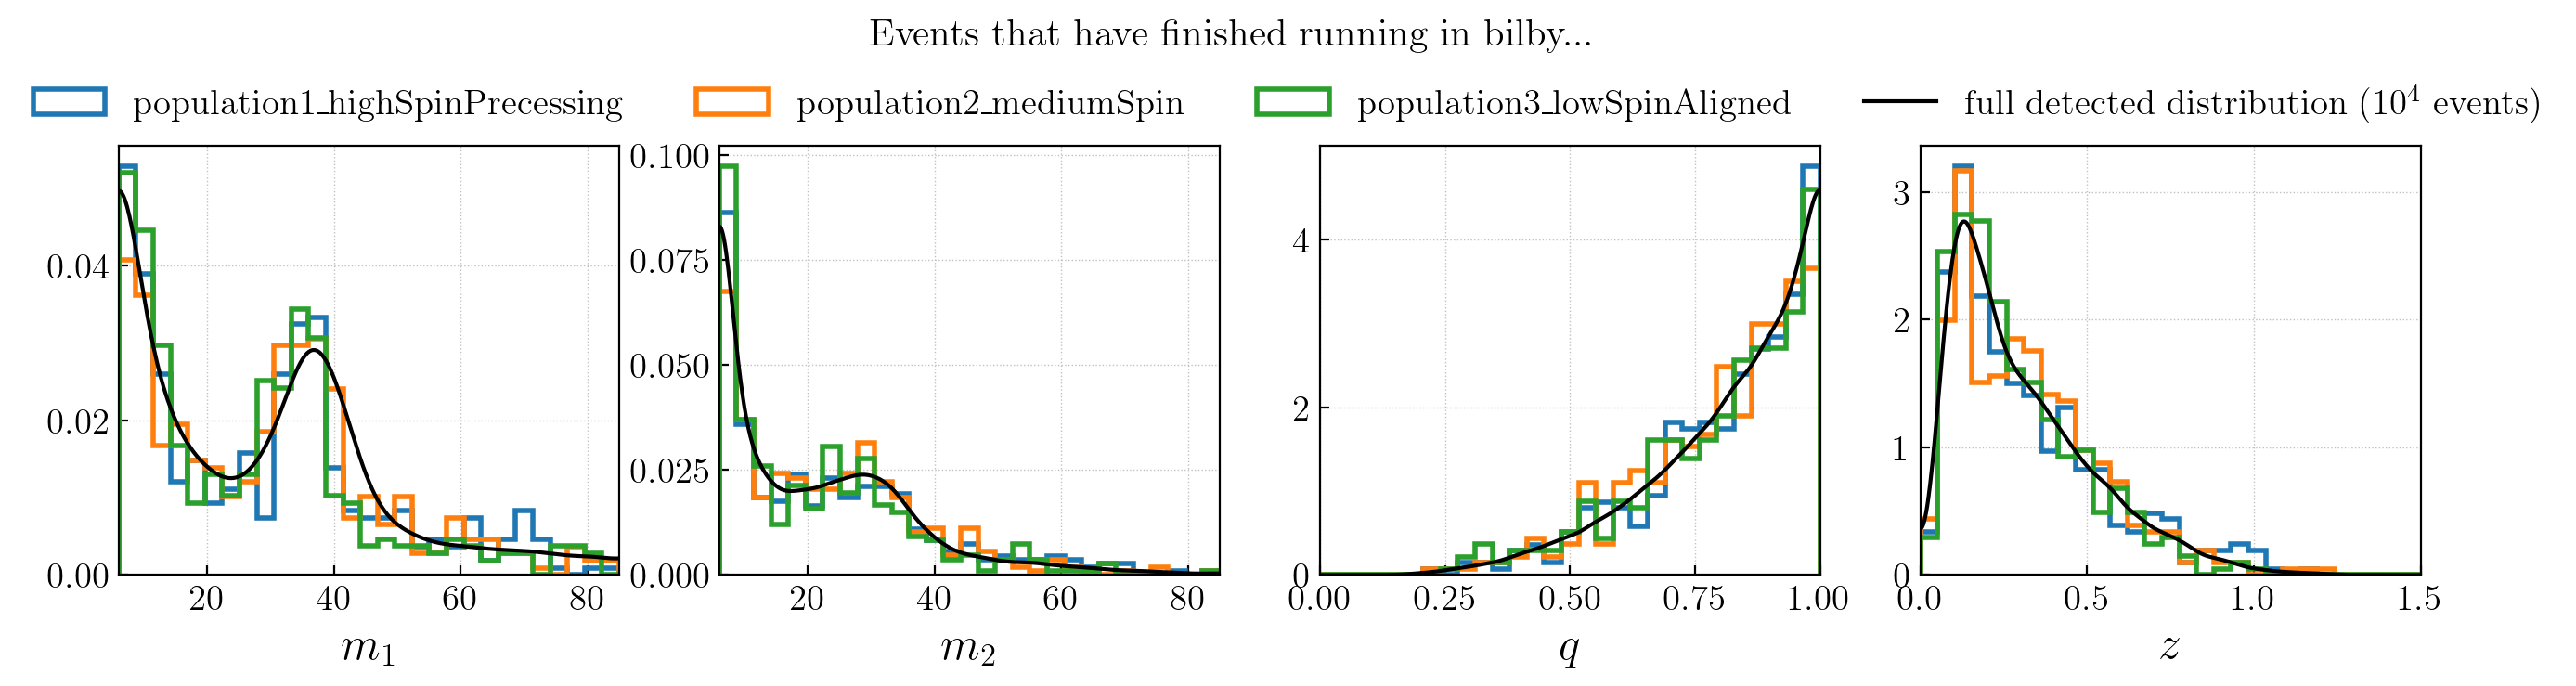

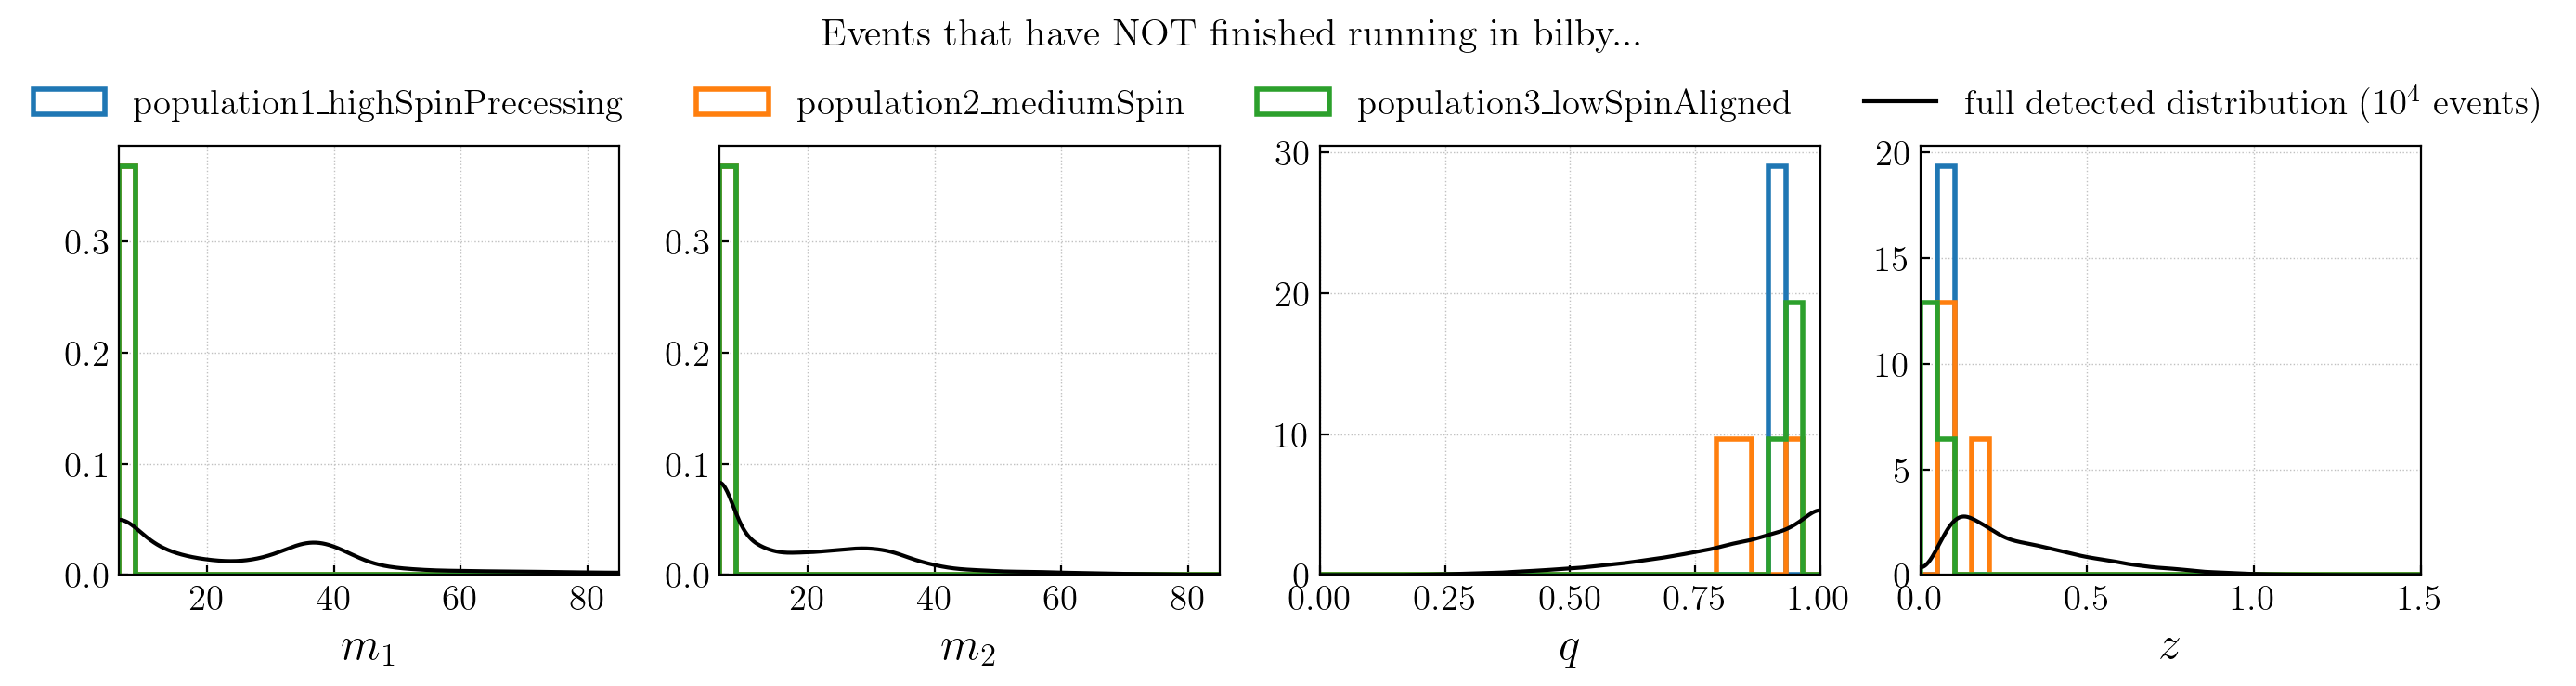

In [74]:
labels = [r'$\mathrm{\textsc{HighSpinPrecessing}}$', r'$\mathrm{\textsc{MediumSpin}}$', r'$\mathrm{\textsc{LowSpinAligned}}$']

for params_dict, ttl in zip([params_dict_finished, params_dict_missing], 
                              ['finished', 'NOT finished']):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

    for pop in pop_names:

        axes[0].hist(params_dict[pop]['m1'], density=True, bins=np.linspace(6, 85, nbins), histtype='step', lw=2, label=pop)

        axes[1].hist(params_dict[pop]['m2'], density=True, bins=np.linspace(6, 85, nbins), histtype='step', lw=2)

        axes[2].hist(params_dict[pop]['q'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2)

        axes[3].hist(params_dict[pop]['z'], density=True, bins=np.linspace(0, 1.5, nbins), histtype='step', lw=2)


    axes[0].plot(m1_grid, kde_dict['m1'], color='k', label=r'full detected distribution ($10^4$ events)')
    axes[1].plot(m2_grid, kde_dict['m2'], color='k')
    axes[2].plot(q_grid, kde_dict['q'], color='k')
    axes[3].plot(z_grid, kde_dict['z'], color='k')

    axes[0].legend(bbox_to_anchor=(-0.2, 1.02, 1., .102), loc='lower left',
                          ncol=4,  borderaxespad=0.)

    axes[0].set_xlim(6,85)
    axes[1].set_xlim(6,85)
    axes[2].set_xlim(0,1)
    axes[3].set_xlim(0, 1.5)

    axes[0].set_xlabel(r'$m_1$')
    axes[1].set_xlabel(r'$m_2$')
    axes[2].set_xlabel(r'$q$')
    axes[3].set_xlabel(r'$z$')  

    plt.suptitle(f'Events that have {ttl} running in bilby...', y=1.11, fontsize=15)

    for ax in axes: 
        ax.grid(ls=':', color='silver', lw=0.5)

    plt.show()

In [13]:
# Print min chirp mass that has finished and max chirp mass that hasn't finished
for pop in pop_names:
    
    mc_finished = chirpmass(np.asarray(params_dict_finished[pop]['m1']), np.asarray(params_dict_finished[pop]['m2']))
    mc_notfinished = chirpmass(np.asarray(params_dict_missing[pop]['m1']), np.asarray(params_dict_missing[pop]['m2']))
    
    imin_finished = np.argmin(mc_finished)
    imax_notfinished = np.argmax(mc_notfinished)
    
    print(pop)
    print(f'minimum chirp mass that has finished is {mc_finished[imin_finished]} for ' 
           + f'job {int(joblists_finished[pop][imin_finished])}')
    print(f'maximum chirp mass that has not finished is {mc_notfinished[imax_notfinished]} for ' 
           + f'job {joblists_missing[pop][imax_notfinished]}')
    print()

population1_highSpinPrecessing
minimum chirp mass that has finished is 5.247759263804977 for job 2217
maximum chirp mass that has not finished is 5.727053350773997 for job 4074

population2_mediumSpin
minimum chirp mass that has finished is 5.345285264604929 for job 9416
maximum chirp mass that has not finished is 7.034626468715954 for job 4301

population3_lowSpinAligned
minimum chirp mass that has finished is 5.228830977821914 for job 3760
maximum chirp mass that has not finished is 5.982425898156009 for job 5686



In [14]:
# Print min total mass that has finished and max total mass that hasn't finished
for pop in pop_names: 
    
    m1s = np.asarray(params_dict_finished[pop]['m1'])
    m2s = np.asarray(params_dict_finished[pop]['m2'])
    mtotals = m1s + m2s
    mchirp = chirpmass(m1s, m2s)
    
    cut = 10
    
    print(pop)
    print(f'no. events with m1 > {cut}:', sum(m1s >= cut))
    print(f'no. events with m2 > {cut}:', sum(m2s >= cut))
    print(f'no. events with Mtotal > {cut}:', sum(mtotals >= cut))
    print(f'no. events with Mchirp > {cut}:', sum(mchirp >= cut))
    print()

population1_highSpinPrecessing
no. events with m1 > 10: 319
no. events with m2 > 10: 283
no. events with Mtotal > 10: 399
no. events with Mchirp > 10: 282

population2_mediumSpin
no. events with m1 > 10: 333
no. events with m2 > 10: 300
no. events with Mtotal > 10: 397
no. events with Mchirp > 10: 304

population3_lowSpinAligned
no. events with m1 > 10: 323
no. events with m2 > 10: 274
no. events with Mtotal > 10: 397
no. events with Mchirp > 10: 270



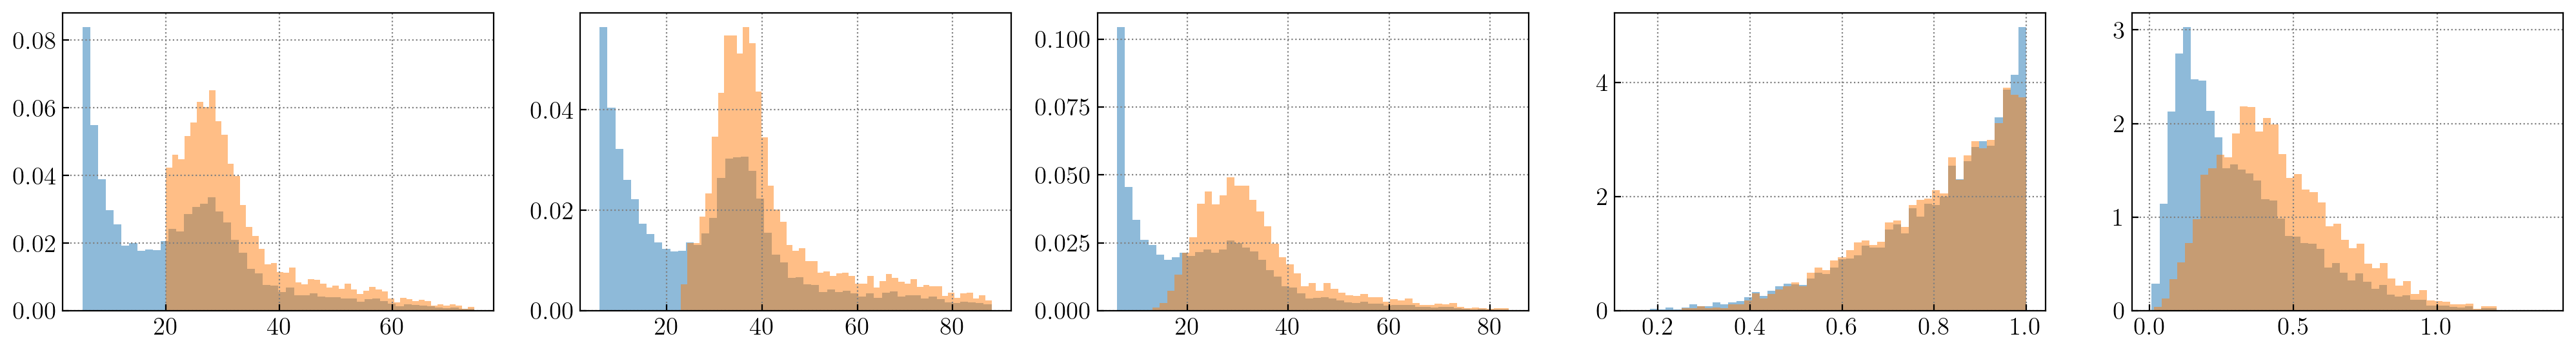

In [15]:
m1s = pop1.m1
m2s = pop1.m2
qs = m2s/m1s
mchirps_all = chirpmass(m1s, m2s)
zs = pop1.z

mask = mchirps_all > 20

kws = dict(density=True, bins=50, alpha=0.5)

plt.figure(figsize=(25,3))

plt.subplot(151)
plt.hist(mchirps_all, **kws)
plt.hist(mchirps_all[mask], **kws)

plt.subplot(152)
plt.hist(m1s, **kws)
plt.hist(m1s[mask], **kws)

plt.subplot(153)
plt.hist(m2s, **kws)
plt.hist(m2s[mask], **kws)

plt.subplot(154)
plt.hist(qs, **kws)
plt.hist(qs[mask], **kws)

plt.subplot(155)
plt.hist(zs, **kws)
plt.hist(zs[mask], **kws)

plt.show()

In [16]:
def p_astro_m1(m1, alpha=-3.51, mMin=6.00, mMax=88.21, lambda_peak=0.033, m0=33.61, sigM=4.72, deltaM=4.88, set_zeros=True): 
    
    """
    Function to calculate for p_astro(m1) for the power law + peak mass model. 
    See table VI in https://arxiv.org/pdf/2111.03634.pdf
    
    Default parameters are those corresponding to the median values reported in 
    https://arxiv.org/pdf/2111.03634.pdf
    
    Parameters
    ----------
    m1 : `numpy.array`
        primary mass samples
    alpha : float
        Spectral index for the power-law of the primary mass distribution
    mMin : float
        Minimum mass of the power-law component of the primary mass distribution
    mMax : float
        Maximum mass of the power-law component of the primary mass distribution
    lambda_peak : float
        Fraction of BBH systems in the Gaussian component
    m0 : float
        Mean of the Gaussian component in the primary mass distribution
    sigM : float
        Width of the Gaussian component in the primary mass distribution
    deltaM : float
        Range of mass tapering at the lower end of the mass distribution
    
    Returns
    -------
    p_m1 : `numpy.array`
        the power law + peak mass model evaluated at the input samples m1
    """
    
    # power law for m1:
    p_m1_pl = (1.+alpha)*m1**alpha/(mMax**(1.+alpha) - mMin**(1.+alpha))
    p_m1_pl[m1>mMax] = 0.
    
    # gaussian peak
    p_m1_peak = np.exp(-0.5*(m1-m0)**2./sigM**2)/np.sqrt(2.*np.pi*sigM**2.)
    p_m1 = lambda_peak*p_m1_peak + (1.-lambda_peak)*p_m1_pl
    
    # smoothing fxn 
    p_m1[m1<mMin+deltaM] = p_m1[m1<mMin+deltaM]*smoothing_fxn(m1[m1<mMin+deltaM]-mMin,deltaM)
    
    if set_zeros:
        p_m1[m1<mMin] = 0.
    
    return p_m1


def smoothing_fxn(m, deltaM): 
    
    """
    Smoothing function that goes into the p_astro(m1,m2) calculation for the power law + peak mass model.
    See eqn. B5 in https://arxiv.org/pdf/2111.03634.pdf
    
    Parameters
    ----------
    m : `numpy.array`
        mass samples to calculate smoothing over
    deltaM : float
        Range of mass tapering at the lower end of the mass distribution
    
    Returns
    -------
    S : `numpy.array`
        the smoothing function evaluated at the input samples m
    """
    
    f = np.exp(deltaM/m + deltaM/(m-deltaM))
    S = 1/(f+1)
    
    return S

In [17]:
pop1_UL = pd.read_json(f_root+'underlying_population1_highSpinPrecessing_fullmassrange.json')

/local/simona.miller/ipykernel_382398/1914194586.py:71: RuntimeWarning: divide by zero encountered in divide
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


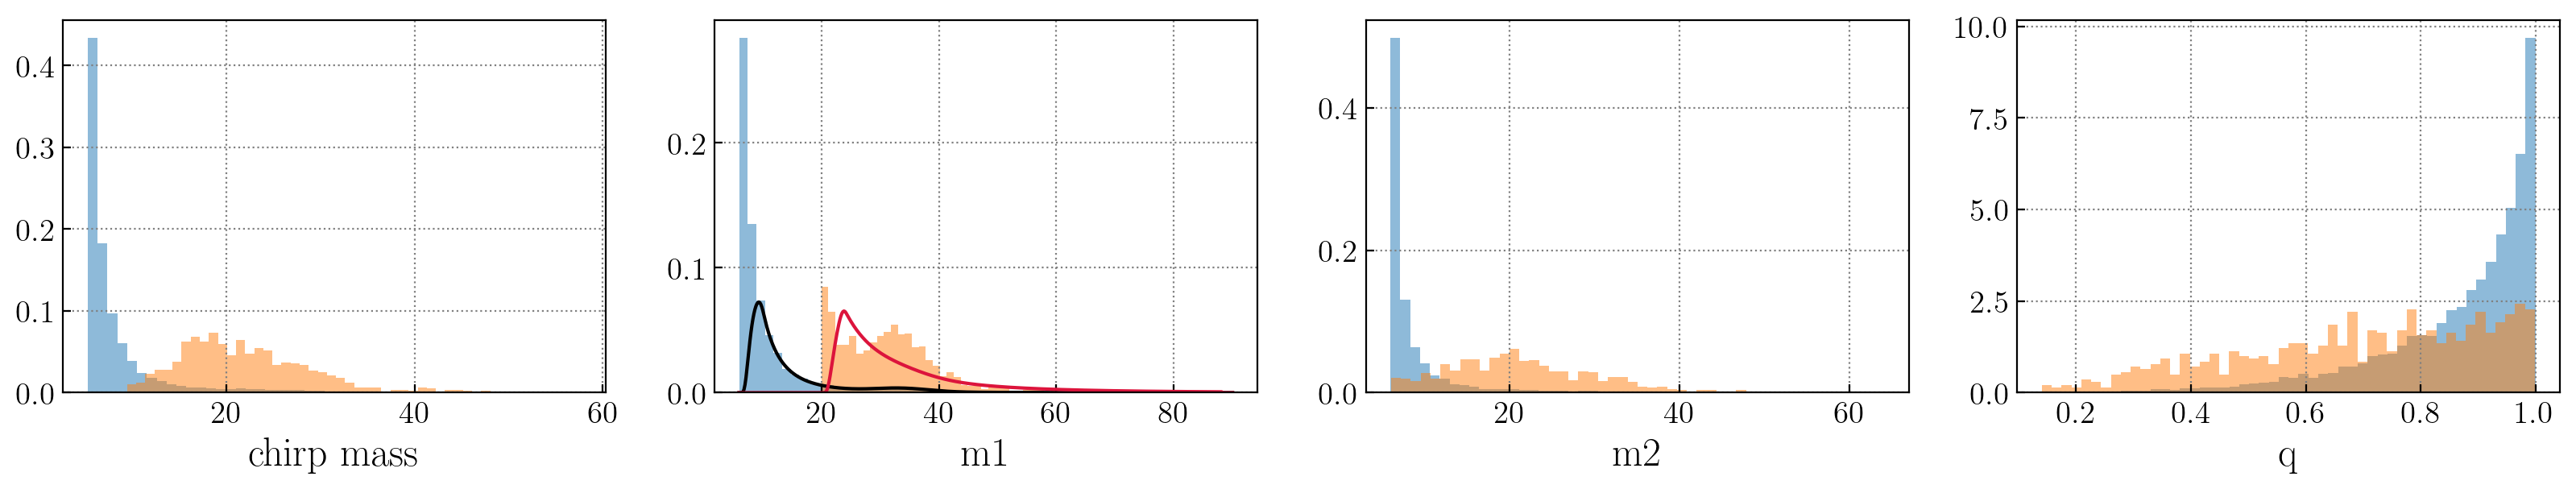

In [18]:
m1s = pop1_UL.m1
m2s = pop1_UL.m2
qs = m2s/m1s
mchirps_all = chirpmass(m1s, m2s)

mask = m1s > 20

kws = dict(density=True, bins=50, alpha=0.5)

m1_grid = np.linspace(6, 90, 500)

plt.figure(figsize=(20,3))

plt.subplot(141)
plt.hist(mchirps_all, **kws)
plt.hist(mchirps_all[mask], **kws)
plt.xlabel('chirp mass')

plt.subplot(142)
plt.hist(m1s, **kws)
plt.hist(m1s[mask], **kws)
plt.plot(m1_grid, p_astro_m1(m1_grid), color='k')
plt.plot(m1_grid, p_astro_m1(m1_grid, mMin=20), color='crimson')
plt.xlabel('m1')

plt.subplot(143)
plt.hist(m2s, **kws)
plt.hist(m2s[mask], **kws)
plt.xlabel('m2')

plt.subplot(144)
plt.hist(qs, **kws)
plt.hist(qs[mask], **kws)
plt.xlabel('q')

plt.show()

In [19]:
chirpmass(6,6)

5.223303379776745

### Plots cornerplots of individual event posteriors which have not yet been investigated

In [20]:
for pop in ['population1_highSpinPrecessing', 'population2_mediumSpin', 'population3_lowSpinAligned']:

    print(pop+'\n')

    for job in joblists_finished[pop]: 

        if job not in joblists_inspected[pop]:

            JOB=int(job) 
            print(JOB)

            try:
                # Read file
                f = '../{1}/job_{0:05d}_result.json'.format(JOB, pop)
                with open(f,'r') as jf:
                    result = json.load(jf)

                # Extract injected parameters
                inj_q = result['injection_parameters']['mass_ratio']
                inj_m1 = result['injection_parameters']['mass_1_source']
                inj_m2 = result['injection_parameters']['mass_2_source']
                inj_z = result['injection_parameters']['redshift']
                inj_chieff = result['injection_parameters']['chi_eff']
                inj_chip = result['injection_parameters']['chi_p']
                inj_chi1 = result['injection_parameters']['a_1']
                inj_chi2 = result['injection_parameters']['a_2']
                inj_costilt1 = result['injection_parameters']['cos_tilt_1']
                inj_costilt2 = result['injection_parameters']['cos_tilt_2']

                inj_Mc = chirpmass(inj_m1, inj_m2)

                # Injected snr
                inj_snr = get_snr(result['meta_data']['likelihood']['interferometers']['H1']['matched_filter_SNR'], 
                                  result['meta_data']['likelihood']['interferometers']['L1']['matched_filter_SNR'], 
                                  result['meta_data']['likelihood']['interferometers']['V1']['matched_filter_SNR'])

                inj_params = [inj_q,inj_Mc,inj_z,inj_chieff,inj_chip,inj_chi1,inj_chi2,inj_costilt1,inj_costilt2,inj_snr]

                print(inj_params)

                # Extract posterior samples
                m1 = np.array(result['posterior']['content']['mass_1_source'])
                m2 = np.array(result['posterior']['content']['mass_2_source'])
                z = np.array(result['posterior']['content']['redshift'])
                chiEff = np.array(result['posterior']['content']['chi_eff'])
                chiP = np.array(result['posterior']['content']['chi_p'])
                chi1 = np.array(result['posterior']['content']['a_1'])
                chi2 = np.array(result['posterior']['content']['a_2'])
                cost1 = np.array(result['posterior']['content']['cos_tilt_1'])
                cost2 = np.array(result['posterior']['content']['cos_tilt_2'])

                # Convert to mass ratio and chirp mass
                q = m2/m1
                Mc = chirpmass(m1, m2)

                # Calculate SNR 
                snr = np.asarray(
                    [get_snr(result['posterior']['content']['H1_matched_filter_snr'][i], 
                          result['posterior']['content']['L1_matched_filter_snr'][i], 
                          result['posterior']['content']['V1_matched_filter_snr'][i]) for i in range(len(result['posterior']['content']['L1_matched_filter_snr']))]
                )

                # Make a corner plot of the posterior samples
                labels = [r"$q$",r"$\mathcal{M}_c$",r'$z$',r'$\chi_\mathrm{eff}$',r'$\chi_\mathrm{p}$',
                          r"$\chi_1$",r"$\chi_2$",r"$\cos\theta_1$",r"$\cos\theta_2$", "snr"]
                ndim = len(labels)
                fig = corner(np.transpose([q,Mc,z,chiEff,chiP,chi1,chi2,cost1,cost2,snr]),labels=labels,fontsize=18)
                axes = np.array(fig.axes).reshape((ndim, ndim))

                # Overplot injected values as horizontal/vertical lines
                for i in range(ndim):
                    ax = axes[i, i]
                    ax.axvline(inj_params[i], color="black")
                for yi in range(ndim):
                    for xi in range(yi):
                        ax = axes[yi, xi]
                        ax.axvline(inj_params[xi], color="black")
                        ax.axhline(inj_params[yi], color="black")

                plt.suptitle(f'Job {JOB}', fontsize=18)
                plt.savefig('./cornerplots/{1}/{0:05d}.pdf'.format(JOB, pop))
                plt.show()

                print()

            except Exception as e:
                print(e)

    # Save the list of jobs we have already plotted             
    np.savetxt(f'{pop}_jobs_checked.txt',joblists_finished[pop],fmt="%d")

population1_highSpinPrecessing

population2_mediumSpin

population3_lowSpinAligned



## Determining which jobs to re-launch

**! RERUN THE FULL SCRIPT BEFORE DOING THIS !**

First, use confidence intervals to identify jobs that *have* finished but don't find the injection: 

In [21]:
def confidenceInterval(value, array_sorted): 
    
    min_idx = np.argmin(np.abs(array_sorted - value))
    
    if value < array_sorted[min_idx]:  
        n = min_idx 
    else: 
        n = min_idx + 1
        
    CI = n/len(array_sorted)
    
    return CI

In [ ]:
finished_jobs_to_redo = {}

for pop in ['population1_highSpinPrecessing', 'population2_mediumSpin', 'population3_lowSpinAligned']:

    print(pop)
    
    jobs_to_redo = []

    for job in joblists_inspected[pop]: 

        JOB=int(job) 

        # Read file
        f = '../{1}/job_{0:05d}_result.json'.format(JOB, pop)
        with open(f,'r') as jf:
            result = json.load(jf)
               
        # Extract injected parameters
        inj_Mc = result['injection_parameters']['chirp_mass']
        inj_q = result['injection_parameters']['mass_ratio']
        inj_z = result['injection_parameters']['redshift']
       
        # Extract posterior samples
        Mc = np.sort(result['posterior']['content']['chirp_mass'])
        q = np.sort(result['posterior']['content']['mass_ratio'])
        z = np.sort(result['posterior']['content']['redshift'])
        
        # Get confidence intervals 
        Mc_CI = confidenceInterval(inj_Mc, Mc)
        q_CI = confidenceInterval(inj_q, q)
        z_CI = confidenceInterval(inj_z, z)
        
        CIs = np.asarray([z_CI, Mc_CI, q_CI])
        
        # Check which injected values fall outside 99% of posterior
        if np.any(CIs[:-1] >= 0.995) or np.any(CIs <= 0.005):
            jobs_to_redo+=[JOB] 
            print(JOB, [Mc, q, z])
            
    # Add to dict and print list
    finished_jobs_to_redo[pop] = jobs_to_redo
    print('')

Second, look at injected parameters of jobs that don't finish: 

In [23]:
for i,pop in enumerate([pop1, pop2, pop3]):

    for job in joblists_missing[pop_names[i]]:
        
        JOB_ID = int(job)
        
        # masses 
        m1 = pop.m1[JOB_ID]
        m2 = pop.m2[JOB_ID]
        q = m2/m1
        Mc = (q/(1.+q)**2)**(3./5.)*(m1+m2)
        
        # redshift
        z = pop.z[JOB_ID]
        
        print(JOB_ID, [Mc, q, z])

4074 [5.727053350773997, 0.9120511991082746, 0.08299794170000001]
4301 [7.034626468715954, 0.9386053758851537, 0.0656151393]
6505 [6.277292146081736, 0.8024224635487017, 0.0842196043]
8630 [5.816365740617316, 0.8504187175856891, 0.1650983803]
5686 [5.982425898156009, 0.9106251798657085, 0.09854019280000001]
6297 [5.4167679567196485, 0.9625829814644075, 0.029525510600000002]
9084 [5.8811182980548455, 0.94785985411432, 0.050865189500000005]


Save list of events to relaunch

In [24]:
to_relaunch_dict = {pop:np.concatenate([finished_jobs_to_redo[pop], joblists_missing[pop]]).tolist() for pop in pop_names}

# date = '071323'
# to_inject_dict_fname = f'../../../Code/IndividualInference/to_inject_dict_{date}.json'
# with open(to_inject_dict_fname, "w") as f:
#     json.dump(to_relaunch_dict, f)

# fname = f'../../../Data/PopulationInferenceInput/to_ignore.json'
# with open(fname, "w") as f:
#     json.dump(to_relaunch_dict, f)

Plot the runs that are need to be relaunched vs. not:

population1_highSpinPrecessing
converged: 358
not converged: 42

population2_mediumSpin
converged: 363
not converged: 37

population3_lowSpinAligned
converged: 351
not converged: 49



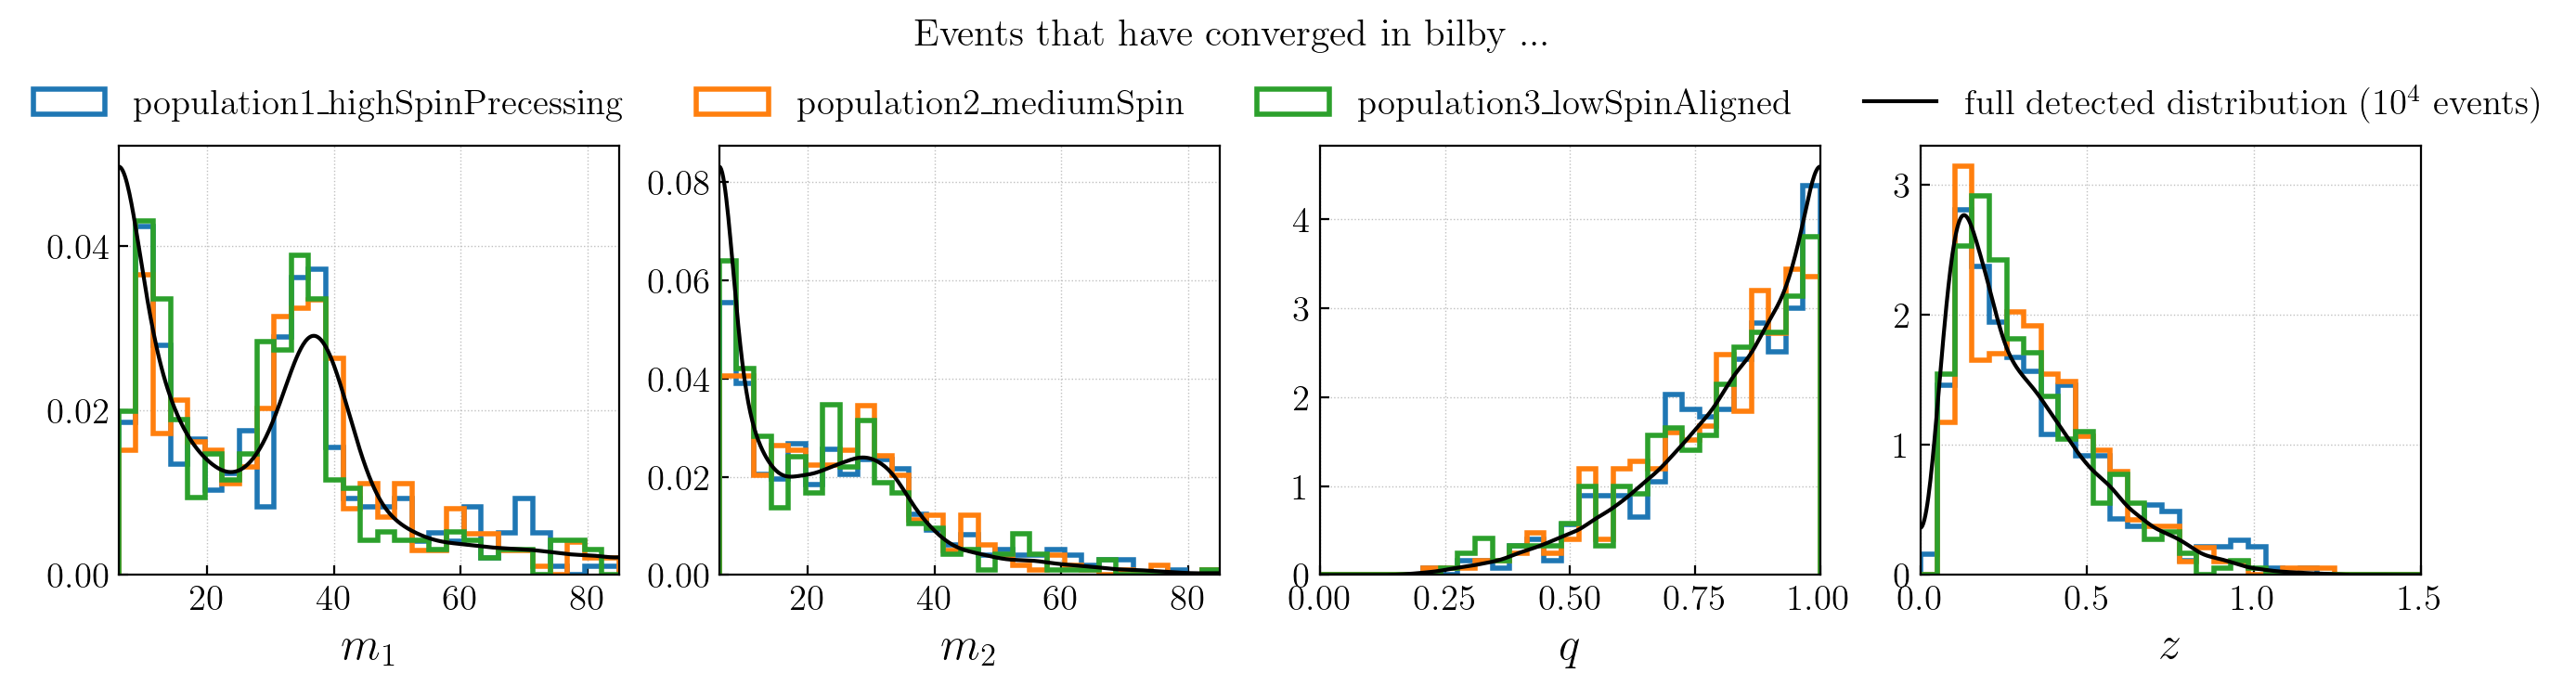

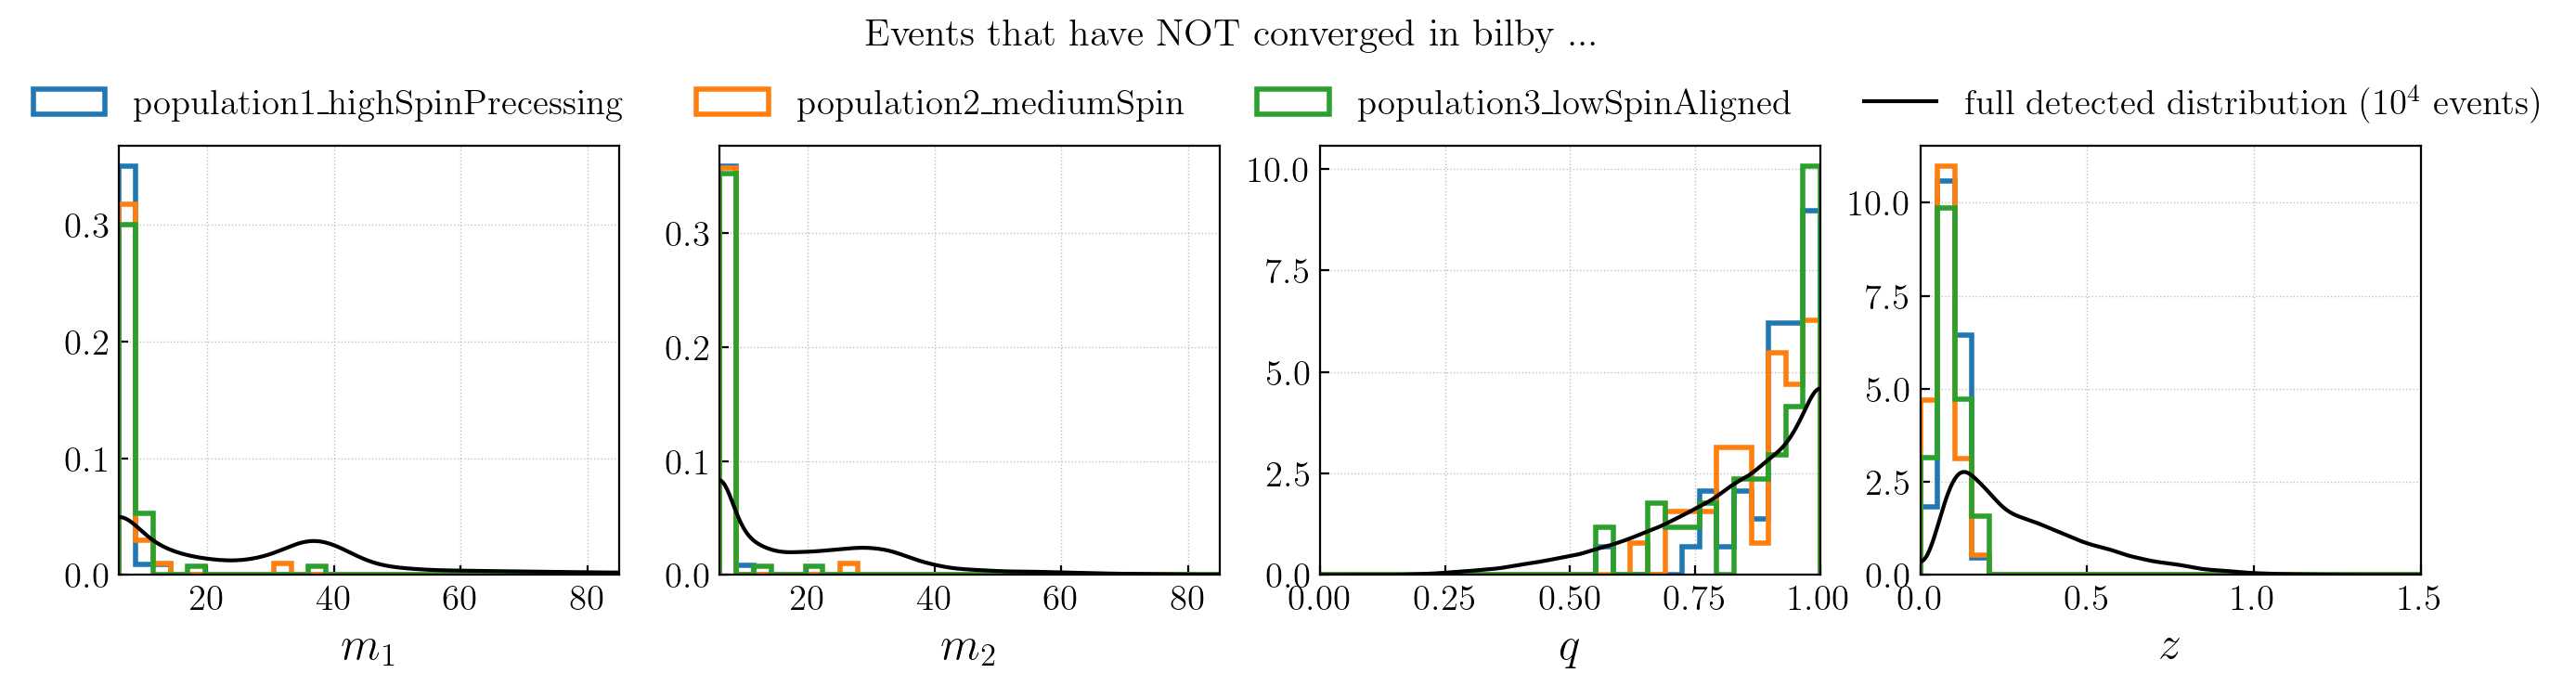

In [25]:
# Generate params for the runs 
converged_dict = {}
for pop in pop_names: 
    
    jobs_all = joblists_all[pop]
    jobs_to_relaunch = to_relaunch_dict[pop]
    converged = [j for j in jobs_all if j not in jobs_to_relaunch]
    converged_dict[pop] = converged
    
    print(pop)
    print('converged:', len(converged))
    print('not converged:',len(jobs_to_relaunch))
    print('')
    
params_dict_done = calculate_params_dict(converged_dict)
params_dict_to_relaunch = calculate_params_dict(to_relaunch_dict)

# Make plots
labels = [r'$\mathrm{\textsc{HighSpinPrecessing}}$', r'$\mathrm{\textsc{MediumSpin}}$', r'$\mathrm{\textsc{LowSpinAligned}}$']

for params_dict, ttl in zip([params_dict_done, params_dict_to_relaunch], 
                              ['converged', 'NOT converged']):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

    for pop in pop_names:

        axes[0].hist(params_dict[pop]['m1'], density=True, bins=np.linspace(6, 85, nbins), histtype='step', lw=2, label=pop)

        axes[1].hist(params_dict[pop]['m2'], density=True, bins=np.linspace(6, 85, nbins), histtype='step', lw=2)

        axes[2].hist(params_dict[pop]['q'], density=True, bins=np.linspace(0, 1, nbins), histtype='step', lw=2)

        axes[3].hist(params_dict[pop]['z'], density=True, bins=np.linspace(0, 1.5, nbins), histtype='step', lw=2)


    axes[0].plot(m1_grid, kde_dict['m1'], color='k', label=r'full detected distribution ($10^4$ events)')
    axes[1].plot(m2_grid, kde_dict['m2'], color='k')
    axes[2].plot(q_grid, kde_dict['q'], color='k')
    axes[3].plot(z_grid, kde_dict['z'], color='k')

    axes[0].legend(bbox_to_anchor=(-0.2, 1.02, 1., .102), loc='lower left',
                          ncol=4,  borderaxespad=0.)

    axes[0].set_xlim(6,85)
    axes[1].set_xlim(6,85)
    axes[2].set_xlim(0,1)
    axes[3].set_xlim(0, 1.5)

    axes[0].set_xlabel(r'$m_1$')
    axes[1].set_xlabel(r'$m_2$')
    axes[2].set_xlabel(r'$q$')
    axes[3].set_xlabel(r'$z$')  

    plt.suptitle(f'Events that have {ttl} in bilby ...', y=1.11, fontsize=15)

    for ax in axes: 
        ax.grid(ls=':', color='silver', lw=0.5)

    plt.show()

Figuring out what `mMin` we need to cut out the non-converged ones

population1_highSpinPrecessing converged with cut m1, m2 > 8: 321
population2_mediumSpin converged with cut m1, m2 > 8: 332
population3_lowSpinAligned converged with cut m1, m2 > 8: 304


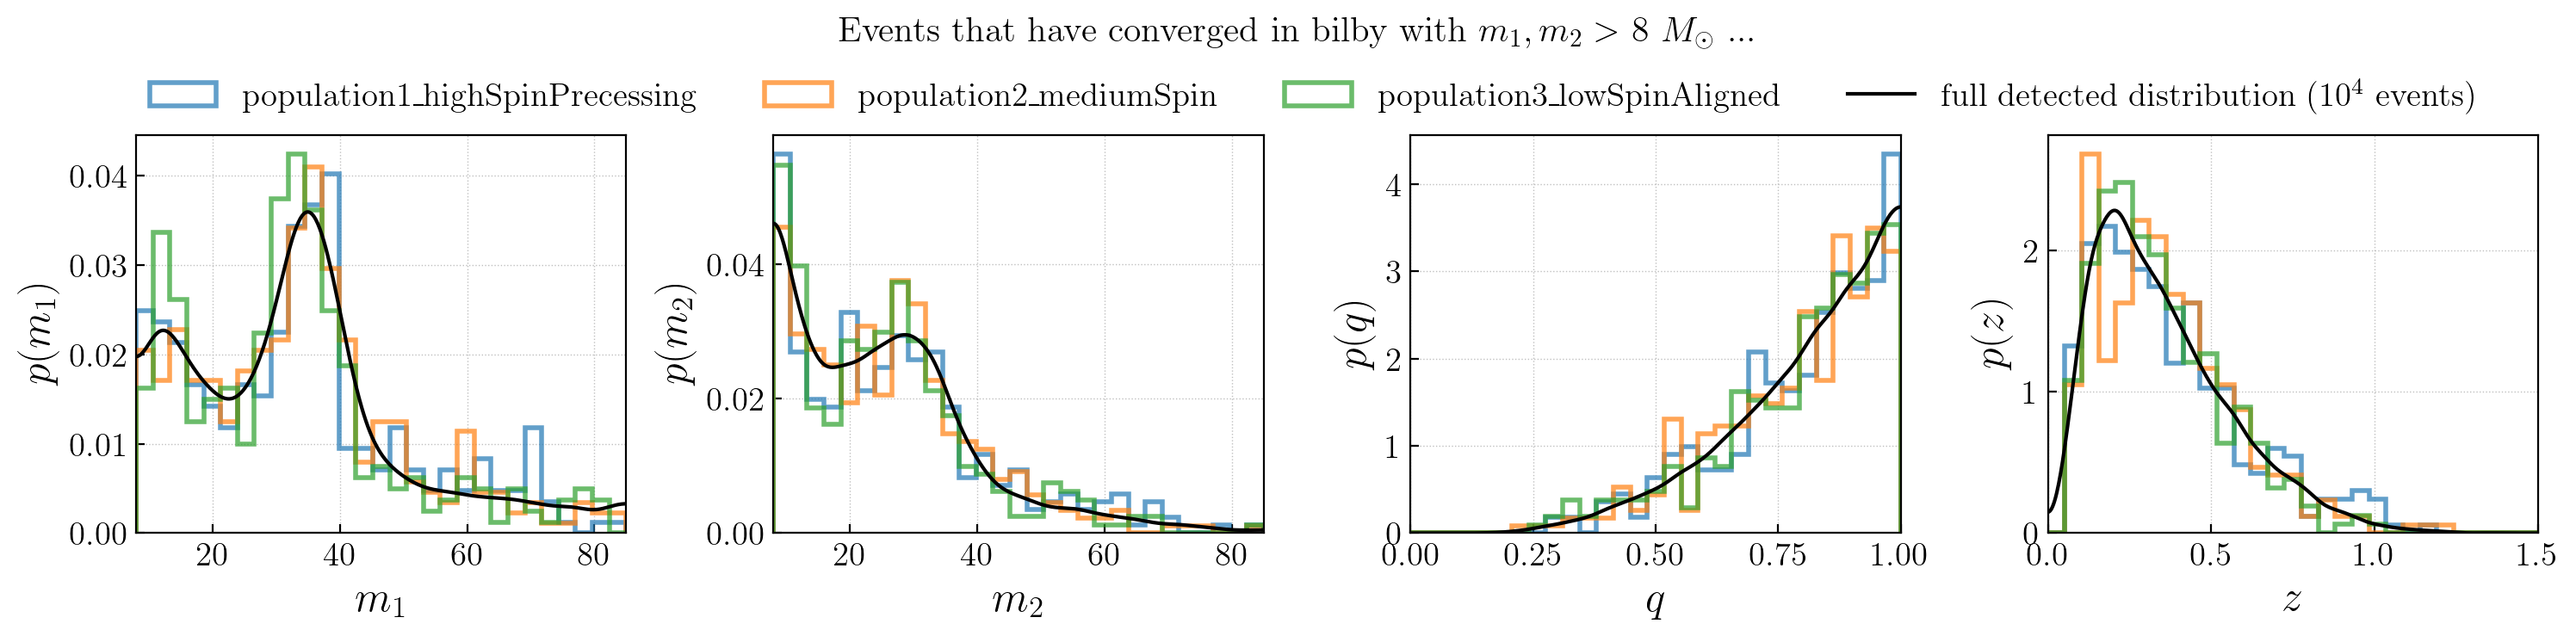

population1_highSpinPrecessing NOT converged with cut m1, m2 > 8: 1
population2_mediumSpin NOT converged with cut m1, m2 > 8: 3
population3_lowSpinAligned NOT converged with cut m1, m2 > 8: 3


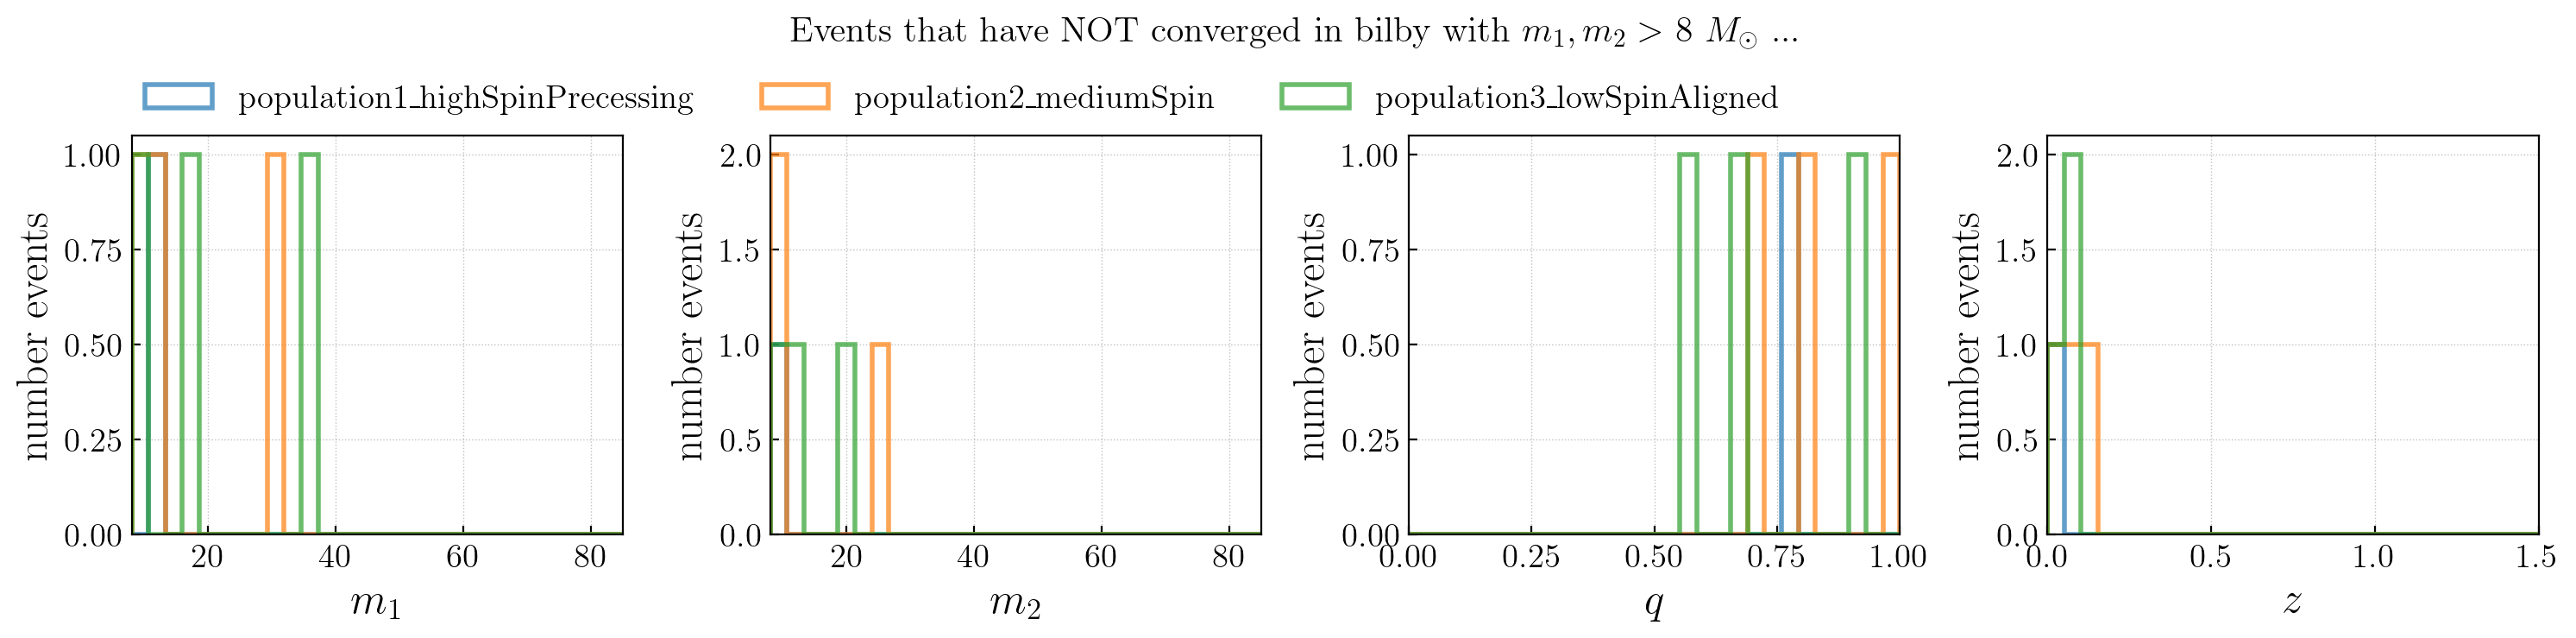

In [85]:
# Make new KDEs
mMin = 8

# Set up grids to evaluate KDEs on
m_grid = np.linspace(mMin,85,500)
q_grid =  np.linspace(0,1,500)
z_grid =  np.linspace(0,1.5,500)

# make and evaluate kdes
m1 = np.concatenate((np.asarray(pop1.m1), np.asarray(pop2.m1), np.asarray(pop3.m1)))
m2 = np.concatenate((np.asarray(pop1.m2), np.asarray(pop2.m2), np.asarray(pop3.m2)))
mask = (m1 > mMin) & (m2 > mMin)
m1_kde = reflective_kde_on_grid(m1[mask], m_grid)
m2_kde = reflective_kde_on_grid(m2[mask], m_grid)

q = np.concatenate((np.asarray(pop1.m2/pop1.m1),  np.asarray(pop2.m2/pop2.m1),  np.asarray(pop3.m2/pop3.m1)))
q_kde = reflective_kde_on_grid(q[mask], q_grid)

z = np.concatenate((np.asarray(pop1.z), np.asarray(pop2.z), np.asarray(pop3.z)))
z_kde =reflective_kde_on_grid(z[mask], z_grid)

# put KDEs into dict
kde_dict_with_cut = {
    'm1':m1_kde, 
    'm2':m2_kde, 
    'q':q_kde, 
    'z':z_kde
}

# Make plots
labels = [r'$\mathrm{\textsc{HighSpinPrecessing}}$', r'$\mathrm{\textsc{MediumSpin}}$', r'$\mathrm{\textsc{LowSpinAligned}}$']

for params_dict, ttl in zip([params_dict_done, params_dict_to_relaunch], 
                              ['converged', 'NOT converged']):
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18,3))

    for pop in pop_names:
        
        m1s = np.asarray(params_dict[pop]['m1'])
        m2s = np.asarray(params_dict[pop]['m2'])
        qs = np.asarray(params_dict[pop]['q'])
        zs = np.asarray(params_dict[pop]['z'])
        
        mask = (m1s > mMin) & (m2s > mMin)
                
        print(pop, ttl, f'with cut m1, m2 > {mMin}:', len(m1s[mask]))
        
        d = True if ttl=='converged' else False

        axes[0].hist(m1s[mask], density=d, alpha=0.7, bins=np.linspace(mMin, 85, nbins), histtype='step', lw=2, label=pop)

        axes[1].hist(m2s[mask], density=d, alpha=0.7, bins=np.linspace(mMin, 85, nbins), histtype='step', lw=2)

        axes[2].hist(qs[mask], density=d, alpha=0.7, bins=np.linspace(0, 1, nbins), histtype='step', lw=2)

        axes[3].hist(zs[mask], density=d, alpha=0.7, bins=np.linspace(0, 1.5, nbins), histtype='step', lw=2)

    axes[0].set_xlim(mMin,85)
    axes[1].set_xlim(mMin,85)
    axes[2].set_xlim(0,1)
    axes[3].set_xlim(0, 1.5)

    axes[0].set_xlabel(r'$m_1$')
    axes[1].set_xlabel(r'$m_2$')
    axes[2].set_xlabel(r'$q$')
    axes[3].set_xlabel(r'$z$')  
    
    if ttl=='converged':
        
        axes[0].set_ylabel(r'$p(m_1)$')
        axes[1].set_ylabel(r'$p(m_2)$')
        axes[2].set_ylabel(r'$p(q)$')
        axes[3].set_ylabel(r'$p(z)$') 
        
        axes[0].plot(m_grid, kde_dict_with_cut['m1'], color='k', label=r'full detected distribution ($10^4$ events)')
        axes[1].plot(m_grid, kde_dict_with_cut['m2'], color='k')
        axes[2].plot(q_grid, kde_dict_with_cut['q'], color='k')
        axes[3].plot(z_grid, kde_dict_with_cut['z'], color='k')
    
    else: 
        for ax in axes: 
            ax.set_ylabel('number events')
            
    
    axes[0].legend(bbox_to_anchor=(0, 1.02, 1., .102), loc='lower left',
                          ncol=4,  borderaxespad=0.)

    plt.suptitle(f'Events that have {ttl} in bilby with $m_1, m_2 >$ {mMin} $M_\odot$ ...', y=1.11, fontsize=15)

    for ax in axes: 
        ax.grid(ls=':', color='silver', lw=0.5)

    plt.subplots_adjust(wspace=0.3)
    plt.show()

In [22]:
# # Cycle through pops
# for pop_name, pop in zip(pop_names, [pop1, pop2, pop3]): 
    
#     print(pop_name)
    
#     pop_copied = pop.copy()
    
#     # Cycle through events
#     for event in to_relaunch_dict[pop_name]:
#         pop_copied.loc[event, 'seed'] = pop.loc[event, 'seed'] + 1
            
#     # Resave pop
#     pop_copied.to_json(f'../../../Data/InjectedPopulationParameters/{pop_name}_fullmassrange.json')

Or do it entirely manually

In [23]:
# Manual relaunches
# to_relaunch_manual = {
#     pop_names[0]:[190, 2675, 7504, 8363], 
#     pop_names[1]:[3668, 9249, 9933], 
#     pop_names[2]:[7445, 8639, 9265, 9828]
# }

# # Combine with auto relaunches
# to_relaunch_dict = {pop:np.concatenate([to_relaunch_manual[pop], joblists_missing[pop]]).tolist() for pop in pop_names}


# to_relaunch_manual = {
#     pop_names[0]:[], 
#     pop_names[1]:[2567, 4263], 
#     pop_names[2]:[1419]
# }

# to_relaunch_dict = to_relaunch_manual

# # Save
# date = '073123'
# to_inject_dict_fname = f'../../../Code/IndividualInference/to_inject_dict_{date}.json'
# with open(to_inject_dict_fname, "w") as f:
#     json.dump(to_relaunch_dict, f)

# # Update seeds 
# for pop_name, pop in zip(pop_names, [pop1, pop2, pop3]): 
    
#     print(pop_name)
    
#     pop_copied = pop.copy()
    
#     # Cycle through events
#     for event in to_relaunch_manual[pop_name]:
#         pop_copied.loc[event, 'seed'] = pop.loc[event, 'seed'] + 1
            
#     # Resave pop
#     pop_copied.to_json(f'../../../Data/InjectedPopulationParameters/{pop_name}_fullmassrange.json')